In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib
from pathlib import Path
import cv2
from typing import Tuple, List, Optional, Dict, Any
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import albumentations as A
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold


In [2]:
import os
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib
from pathlib import Path
import cv2
from typing import Tuple, List, Optional, Dict, Any
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import albumentations as A
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

warnings.filterwarnings('ignore')

class DICOMLoader:
    """Optimized DICOM loading utilities for medical imaging"""
    
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.series_dir = self.data_dir / "series"
        
    def load_dicom_series(self, series_uid: str, target_spacing: Optional[Tuple[float, float, float]] = None) -> Dict[str, Any]:
        """
        Load complete DICOM series with metadata
        
        Args:
            series_uid: Series instance UID
            target_spacing: Target voxel spacing for resampling (z, y, x)
            
        Returns:
            Dict containing volume, spacing, metadata
        """
        series_path = self.series_dir / series_uid
        
        if not series_path.exists():
            raise FileNotFoundError(f"Series not found: {series_uid}")
        
        # Get all DICOM files
        dicom_files = sorted(list(series_path.glob("*.dcm")))
        
        if len(dicom_files) == 0:
            raise ValueError(f"No DICOM files found in {series_path}")
        
        # Load first file to get metadata
        first_ds = pydicom.dcmread(dicom_files[0])
        
        # Extract key metadata
        metadata = {
            'series_uid': series_uid,
            'modality': getattr(first_ds, 'Modality', 'Unknown'),
            'slice_count': len(dicom_files),
            'rows': first_ds.Rows,
            'cols': first_ds.Columns,
            'pixel_spacing': getattr(first_ds, 'PixelSpacing', [1.0, 1.0]),
            'slice_thickness': getattr(first_ds, 'SliceThickness', 1.0),
        }
        
        # Load all slices
        slices = []
        positions = []
        
        for dcm_file in dicom_files:
            ds = pydicom.dcmread(dcm_file)
            
            # Get pixel array
            pixel_array = ds.pixel_array.astype(np.float32)
            
            # Apply rescale slope/intercept if present
            if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
                pixel_array = pixel_array * float(ds.RescaleSlope) + float(ds.RescaleIntercept)
            
            slices.append(pixel_array)
            
            # Get slice position for proper ordering
            if hasattr(ds, 'ImagePositionPatient'):
                positions.append(float(ds.ImagePositionPatient[2]))  # Z coordinate
            else:
                positions.append(float(getattr(ds, 'InstanceNumber', 0)))
        
        # Sort slices by position
        if positions:
            sorted_indices = np.argsort(positions)
            slices = [slices[i] for i in sorted_indices]
            positions = [positions[i] for i in sorted_indices]
        
        # Stack into 3D volume (Z, Y, X)
        volume = np.stack(slices, axis=0)
        
        # Calculate actual spacing
        spacing = [
            abs(positions[1] - positions[0]) if len(positions) > 1 else metadata['slice_thickness'],
            metadata['pixel_spacing'][0],
            metadata['pixel_spacing'][1]
        ]
        
        metadata['spacing'] = spacing
        metadata['original_shape'] = volume.shape
        
        # Apply modality-specific preprocessing
        volume = self._preprocess_by_modality(volume, metadata['modality'])
        
        # Resample if target spacing provided
        if target_spacing is not None:
            volume = self._resample_volume(volume, spacing, target_spacing)
            metadata['resampled_spacing'] = target_spacing
            metadata['resampled_shape'] = volume.shape
        
        return {
            'volume': volume,
            'metadata': metadata
        }
    
    def _preprocess_by_modality(self, volume: np.ndarray, modality: str) -> np.ndarray:
        """Apply modality-specific preprocessing"""
        
        if modality in ['CTA', 'MRA']:
            # Angiography - focus on vessels
            # Apply soft windowing for vessels
            volume = np.clip(volume, -200, 800)  # Typical vessel window
            volume = (volume + 200) / 1000.0  # Normalize to [0, 1]
            
        elif 'MRI' in modality or 'MR' in modality:
            # MRI - normalize per volume
            volume = volume - np.min(volume)
            volume = volume / (np.max(volume) + 1e-8)
            
        else:
            # Default normalization
            p1, p99 = np.percentile(volume, [1, 99])
            volume = np.clip(volume, p1, p99)
            volume = (volume - p1) / (p99 - p1 + 1e-8)
        
        return volume.astype(np.float32)
    
    def _resample_volume(self, volume: np.ndarray, current_spacing: List[float], 
                        target_spacing: Tuple[float, float, float]) -> np.ndarray:
        """Resample volume to target spacing"""
        
        current_spacing = np.array(current_spacing)
        target_spacing = np.array(target_spacing)
        
        # Calculate resize factors
        resize_factor = current_spacing / target_spacing
        new_shape = (volume.shape * resize_factor).astype(int)
        
        # Use OpenCV for efficient resampling
        resampled_slices = []
        for i in range(volume.shape[0]):
            if resize_factor[1] != 1.0 or resize_factor[2] != 1.0:
                slice_resized = cv2.resize(
                    volume[i], 
                    (new_shape[2], new_shape[1]), 
                    interpolation=cv2.INTER_LINEAR
                )
            else:
                slice_resized = volume[i]
            resampled_slices.append(slice_resized)
        
        resampled_volume = np.stack(resampled_slices, axis=0)
        
        # Handle Z-axis resampling if needed
        if resize_factor[0] != 1.0:
            # Simple linear interpolation along Z-axis
            from scipy.ndimage import zoom
            resampled_volume = zoom(resampled_volume, 
                                  [resize_factor[0], 1.0, 1.0], 
                                  order=1, mode='nearest')
        
        return resampled_volume

class NIfTILoader:
    """NIfTI segmentation loader"""
    
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.seg_dir = self.data_dir / "segmentations"
        
        # Segmentation label mapping
        self.label_mapping = {
            1: "Other Posterior Circulation",
            2: "Basilar Tip", 
            3: "Right Posterior Communicating Artery",
            4: "Left Posterior Communicating Artery",
            5: "Right Infraclinoid Internal Carotid Artery",
            6: "Left Infraclinoid Internal Carotid Artery",
            7: "Right Supraclinoid Internal Carotid Artery", 
            8: "Left Supraclinoid Internal Carotid Artery",
            9: "Right Middle Cerebral Artery",
            10: "Left Middle Cerebral Artery",
            11: "Right Anterior Cerebral Artery",
            12: "Left Anterior Cerebral Artery",
            13: "Anterior Communicating Artery"
        }
    
    def load_segmentation(self, series_uid: str) -> Optional[Dict[str, Any]]:
        """Load vessel segmentation if available"""
        
        seg_file = self.seg_dir / f"{series_uid}.nii"
        
        if not seg_file.exists():
            return None
        
        # Load NIfTI file
        nii_img = nib.load(seg_file)
        segmentation = nii_img.get_fdata().astype(np.uint8)
        
        # Get unique labels present
        unique_labels = np.unique(segmentation)
        present_structures = {
            label: self.label_mapping.get(label, f"Unknown_{label}") 
            for label in unique_labels if label > 0
        }
        
        return {
            'segmentation': segmentation,
            'present_structures': present_structures,
            'affine': nii_img.affine,
            'header': nii_img.header
        }

class AneurysmDataset(Dataset):
    """PyTorch Dataset for aneurysm detection"""
    
    def __init__(self, 
                 df: pd.DataFrame,
                 data_dir: str,
                 mode: str = 'train',
                 target_size: Tuple[int, int, int] = (64, 256, 256),
                 target_spacing: Tuple[float, float, float] = (2.0, 1.0, 1.0),
                 use_segmentation: bool = True,
                 transforms: Optional[A.Compose] = None):
        
        self.df = df.copy()
        self.data_dir = Path(data_dir)
        self.mode = mode
        self.target_size = target_size
        self.target_spacing = target_spacing
        self.use_segmentation = use_segmentation
        self.transforms = transforms
        
        self.dicom_loader = DICOMLoader(data_dir)
        self.nifti_loader = NIfTILoader(data_dir)
        
        # Define label columns
        self.label_columns = [
            'Left Infraclinoid Internal Carotid Artery',
            'Right Infraclinoid Internal Carotid Artery', 
            'Left Supraclinoid Internal Carotid Artery',
            'Right Supraclinoid Internal Carotid Artery',
            'Left Middle Cerebral Artery',
            'Right Middle Cerebral Artery',
            'Anterior Communicating Artery',
            'Left Anterior Cerebral Artery', 
            'Right Anterior Cerebral Artery',
            'Left Posterior Communicating Artery',
            'Right Posterior Communicating Artery',
            'Basilar Tip',
            'Other Posterior Circulation'
        ]
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        series_uid = row['SeriesInstanceUID']
        
        try:
            # Load DICOM volume
            dicom_data = self.dicom_loader.load_dicom_series(
                series_uid, 
                target_spacing=self.target_spacing
            )
            volume = dicom_data['volume']
            metadata = dicom_data['metadata']
            
            # Resize to target size
            volume = self._resize_volume(volume, self.target_size)
            
            # Load segmentation if available and requested
            segmentation = None
            if self.use_segmentation:
                seg_data = self.nifti_loader.load_segmentation(series_uid)
                if seg_data is not None:
                    segmentation = seg_data['segmentation']
                    segmentation = self._resize_volume(segmentation, self.target_size)
            
            # Prepare labels
            if self.mode == 'train':
                labels = torch.tensor([
                    row[col] for col in self.label_columns
                ], dtype=torch.float32)
                
                main_label = torch.tensor(row['Aneurysm Present'], dtype=torch.float32)
            else:
                labels = torch.zeros(len(self.label_columns))
                main_label = torch.tensor(0.0)
            
            # Convert to tensor
            volume = torch.tensor(volume, dtype=torch.float32).unsqueeze(0)  # Add channel dim
            
            # Apply transforms if provided
            if self.transforms is not None:
                # Apply 3D transforms (implement custom 3D augmentation)
                volume = self._apply_3d_transforms(volume)
            
            sample = {
                'volume': volume,
                'labels': labels,
                'main_label': main_label,
                'series_uid': series_uid,
                'metadata': metadata
            }
            
            if segmentation is not None:
                sample['segmentation'] = torch.tensor(segmentation, dtype=torch.float32).unsqueeze(0)
            
            return sample
            
        except Exception as e:
            print(f"Error loading {series_uid}: {e}")
            # Return dummy data to prevent training crashes
            return self._get_dummy_sample()
    
    def _resize_volume(self, volume: np.ndarray, target_size: Tuple[int, int, int]) -> np.ndarray:
        """Resize volume to target size"""
        
        if volume.shape == target_size:
            return volume
        
        # Resize each dimension
        z_factor = target_size[0] / volume.shape[0]
        y_factor = target_size[1] / volume.shape[1] 
        x_factor = target_size[2] / volume.shape[2]
        
        from scipy.ndimage import zoom
        resized_volume = zoom(volume, [z_factor, y_factor, x_factor], order=1, mode='nearest')
        
        return resized_volume
    
    def _apply_3d_transforms(self, volume: torch.Tensor) -> torch.Tensor:
        """Apply 3D augmentations"""
        # Placeholder for 3D augmentations
        # Can implement random rotation, flip, noise, etc.
        return volume
    
    def _get_dummy_sample(self):
        """Return dummy sample for error cases"""
        return {
            'volume': torch.zeros((1, *self.target_size)),
            'labels': torch.zeros(len(self.label_columns)),
            'main_label': torch.tensor(0.0),
            'series_uid': 'dummy',
            'metadata': {}
        }

def create_folds(df: pd.DataFrame, n_splits: int = 5, random_state: int = 42) -> pd.DataFrame:
    """Create stratified group k-fold splits"""
    
    df = df.copy()
    
    # Create groups based on PatientID if available, otherwise use SeriesInstanceUID
    if 'PatientID' in df.columns:
        df['group'] = df['PatientID']
    else:
        # Extract patient info from SeriesInstanceUID or create groups
        df['group'] = df['SeriesInstanceUID'].apply(lambda x: x[:20])  # Use prefix as group
    
    # Use main aneurysm label for stratification
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    df['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(df, df['Aneurysm Present'], df['group'])):
        df.loc[val_idx, 'fold'] = fold
    
    return df

def get_data_info(data_dir: str) -> Dict[str, Any]:
    """Get comprehensive dataset information"""
    
    data_path = Path(data_dir)
    
    # Load training data
    train_df = pd.read_csv(data_path / 'train.csv')
    localizers_df = pd.read_csv(data_path / 'train_localizers.csv')
    
    # Count available files
    series_dir = data_path / 'series'
    available_series = [d.name for d in series_dir.iterdir() if d.is_dir()]
    
    seg_dir = data_path / 'segmentations' 
    available_segs = [f.stem for f in seg_dir.glob('*.nii')] if seg_dir.exists() else []
    
    info = {
        'total_series': len(train_df),
        'available_series': len(available_series),
        'available_segmentations': len(available_segs),
        'modality_distribution': train_df['Modality'].value_counts().to_dict(),
        'aneurysm_prevalence': train_df['Aneurysm Present'].mean(),
        'age_stats': train_df['PatientAge'].describe().to_dict(),
        'gender_distribution': train_df['PatientSex'].value_counts().to_dict(),
        'localizations_count': len(localizers_df)
    }
    
    return info

# Usage example and testing
if __name__ == "__main__":
    # Test the data loaders
    data_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection"
    
    # Get dataset info
    info = get_data_info(data_dir)
    print("Dataset Info:", info)
    
    # Load training data
    train_df = pd.read_csv(f"{data_dir}/train.csv")
    
    # Create folds
    train_df = create_folds(train_df, n_splits=5)
    
    # Test dataset
    dataset = AneurysmDataset(
        df=train_df.head(10),  # Test with small subset
        data_dir=data_dir,
        mode='train',
        target_size=(32, 128, 128),  # Smaller for testing
        use_segmentation=True
    )
    
    print(f"Dataset length: {len(dataset)}")
    
    # Test loading one sample
    try:
        sample = dataset[0]
        print(f"Sample keys: {sample.keys()}")
        print(f"Volume shape: {sample['volume'].shape}")
        print(f"Labels: {sample['labels']}")
    except Exception as e:
        print(f"Error testing dataset: {e}")

Dataset Info: {'total_series': 4348, 'available_series': 4348, 'available_segmentations': 356, 'modality_distribution': {'CTA': 1808, 'MRA': 1252, 'MRI T2': 983, 'MRI T1post': 305}, 'aneurysm_prevalence': 0.4284728610855566, 'age_stats': {'count': 4348.0, 'mean': 58.46688132474701, 'std': 15.84123141002202, 'min': 18.0, '25%': 48.0, '50%': 60.0, '75%': 70.0, 'max': 89.0}, 'gender_distribution': {'Female': 3005, 'Male': 1343}, 'localizations_count': 2249}
Dataset length: 10
Sample keys: dict_keys(['volume', 'labels', 'main_label', 'series_uid', 'metadata'])
Volume shape: torch.Size([1, 32, 128, 128])
Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


🔍 RSNA INTRACRANIAL ANEURYSM DETECTION - DATASET ANALYSIS
📊 BASIC STATISTICS:
   Total Cases: 4,348
   Positive Cases: 1,863 (42.8%)
   Negative Cases: 2,485 (57.2%)
   Total Localizations: 2,249

🏥 MODALITY DISTRIBUTION:
   CTA: 1,808 (41.6%)
   MRA: 1,252 (28.8%)
   MRI T2: 983 (22.6%)
   MRI T1post: 305 (7.0%)

👥 DEMOGRAPHICS:
   Age: 58.5 ± 15.8 years
   Age Range: 18 - 89 years
   Female: 3,005 (69.1%)
   Male: 1,343 (30.9%)

🧠 VESSEL SEGMENTATIONS:
   Available: 356 (8.2%)


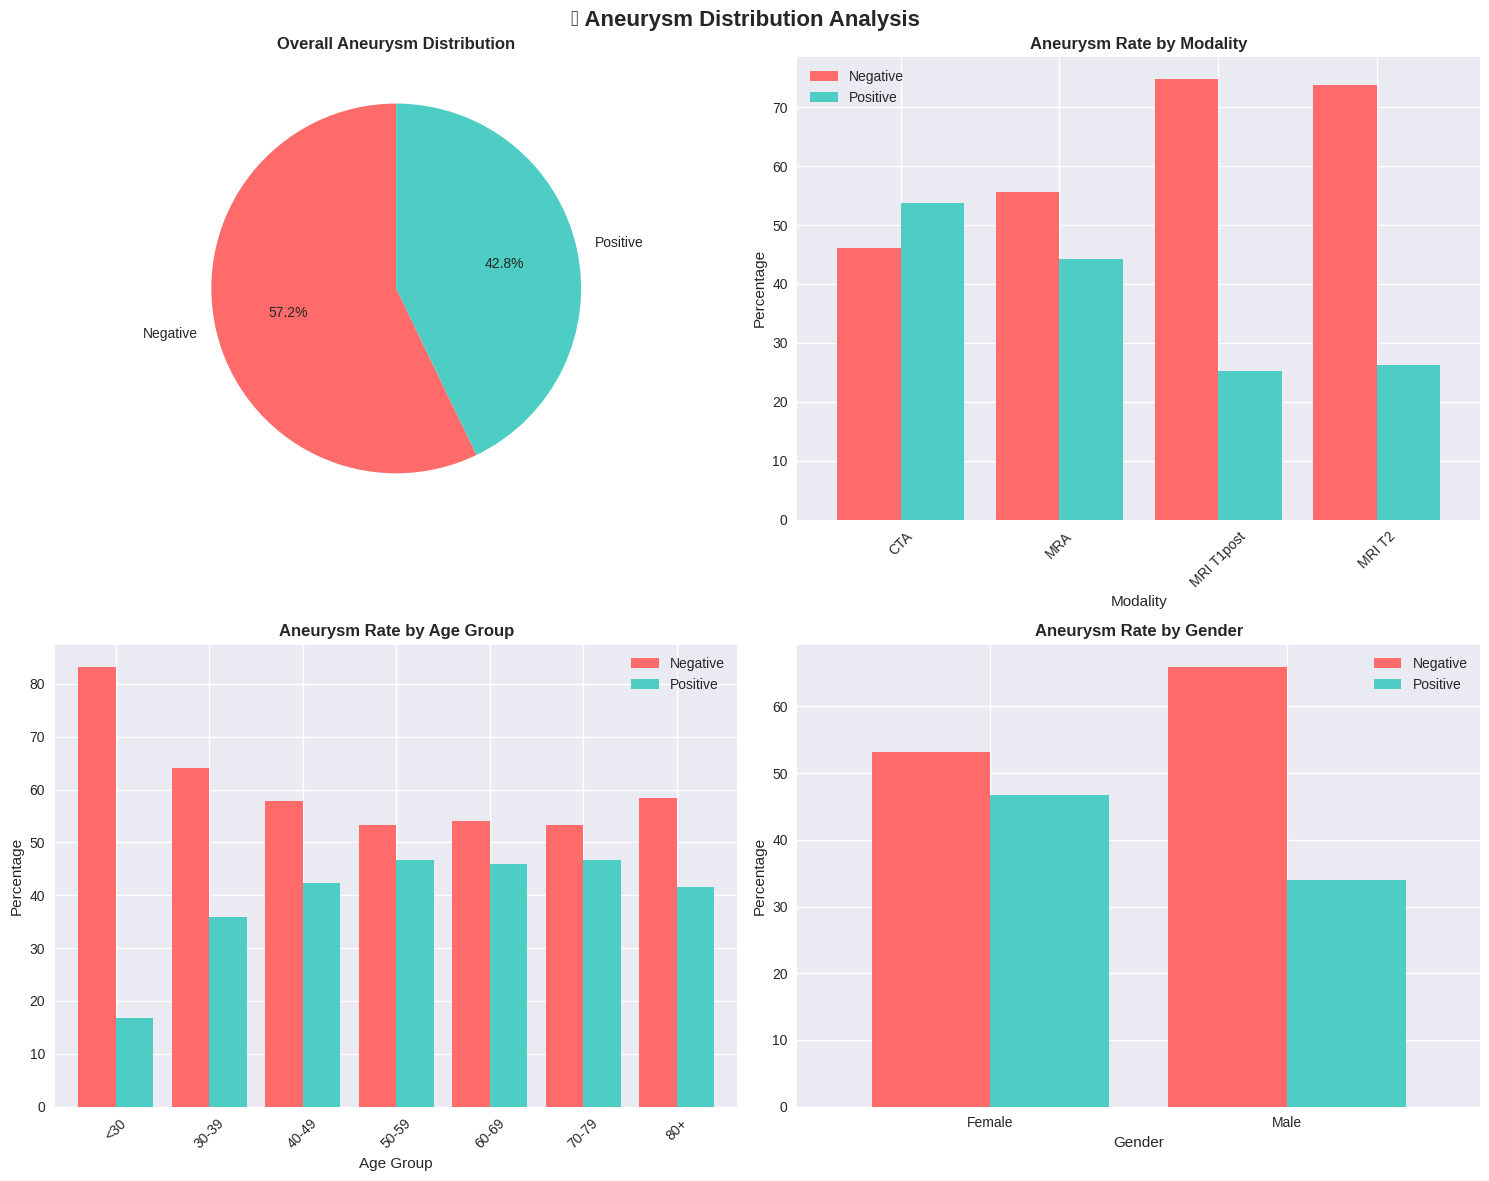


🧠 ANATOMICAL LOCATION ANALYSIS:
   L_Infraclinoid_ICA: 78 (1.79%)
   R_Infraclinoid_ICA: 98 (2.25%)
   L_Supraclinoid_ICA: 330 (7.59%)
   R_Supraclinoid_ICA: 278 (6.39%)
   L_MCA: 219 (5.04%)
   R_MCA: 294 (6.76%)
   AComm: 363 (8.35%)
   L_ACA: 46 (1.06%)
   R_ACA: 56 (1.29%)
   L_PComm: 86 (1.98%)
   R_PComm: 101 (2.32%)
   Basilar_Tip: 110 (2.53%)
   Other_Posterior: 113 (2.60%)


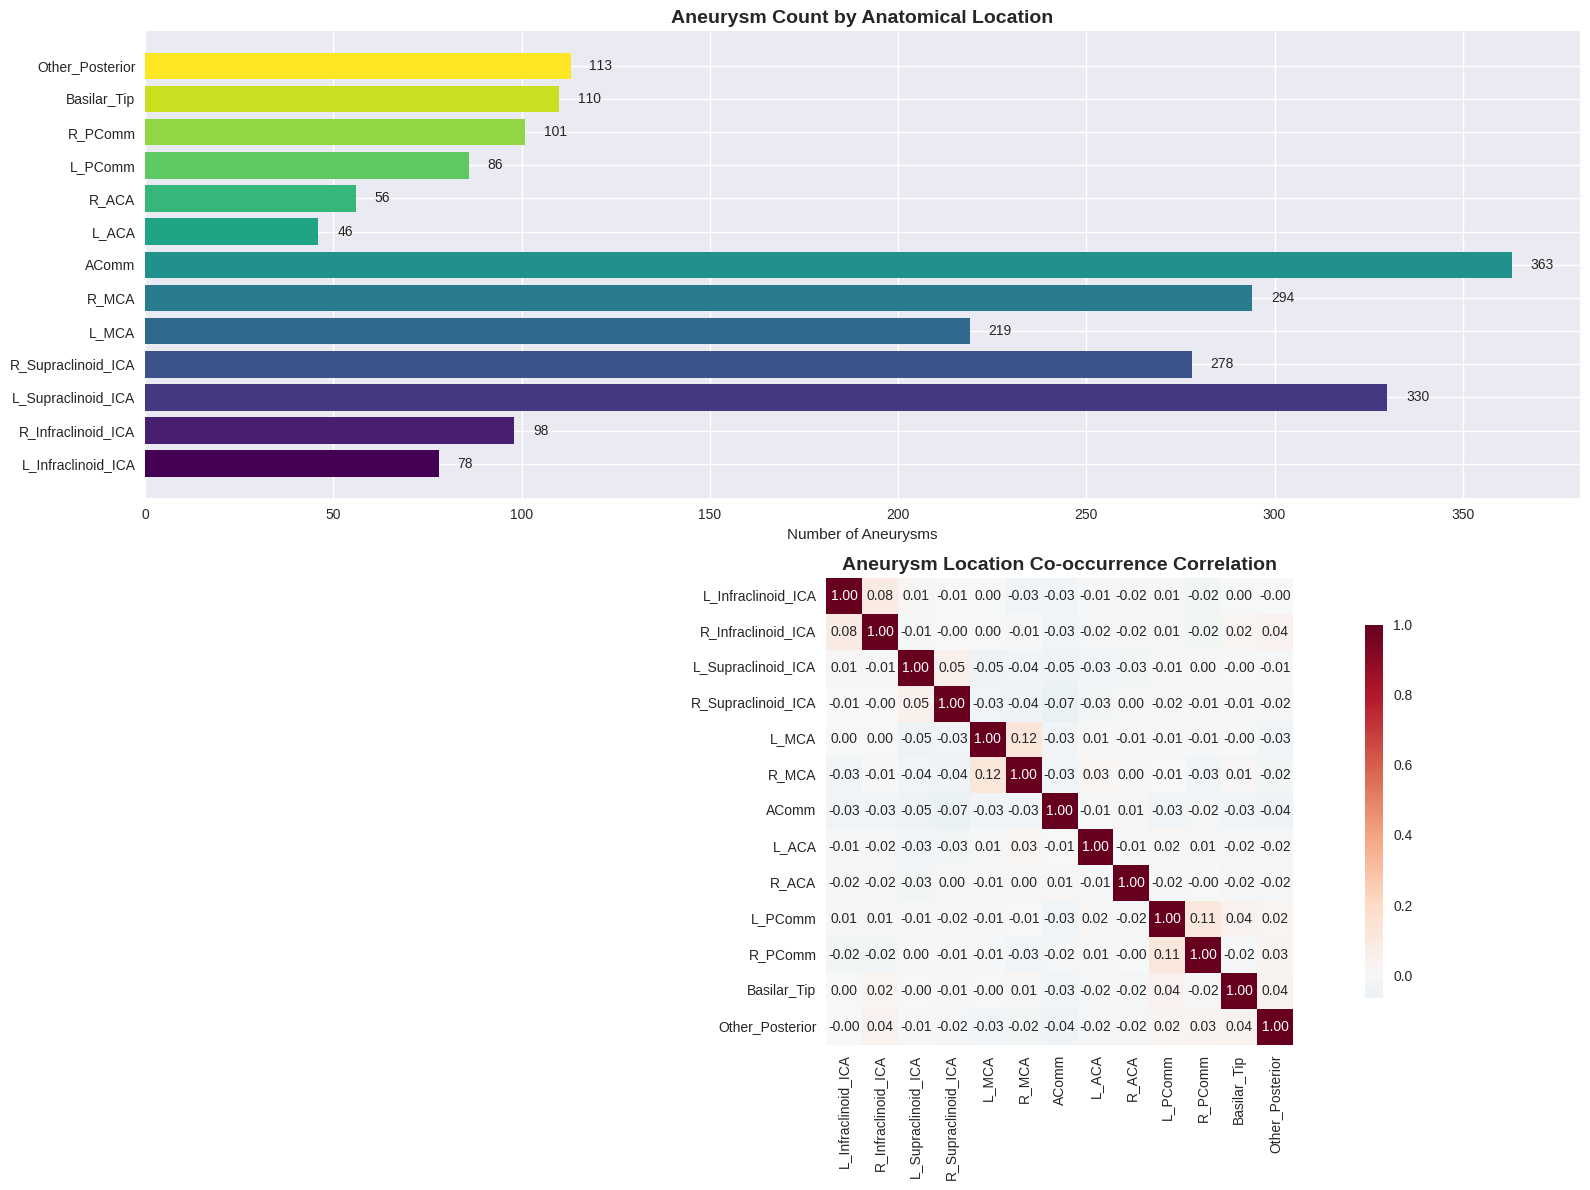


🔢 MULTIPLE ANEURYSM ANALYSIS:
   Aneurysms per case:
   0 aneurysms: 2,485 cases (57.2%)
   1 aneurysms: 1,614 cases (37.1%)
   2 aneurysms: 202 cases (4.6%)
   3 aneurysms: 37 cases (0.9%)
   4 aneurysms: 7 cases (0.2%)
   5 aneurysms: 3 cases (0.1%)

   Average localizations per positive case: 1.21
   Localization coverage: 1861/1863 (99.9%)


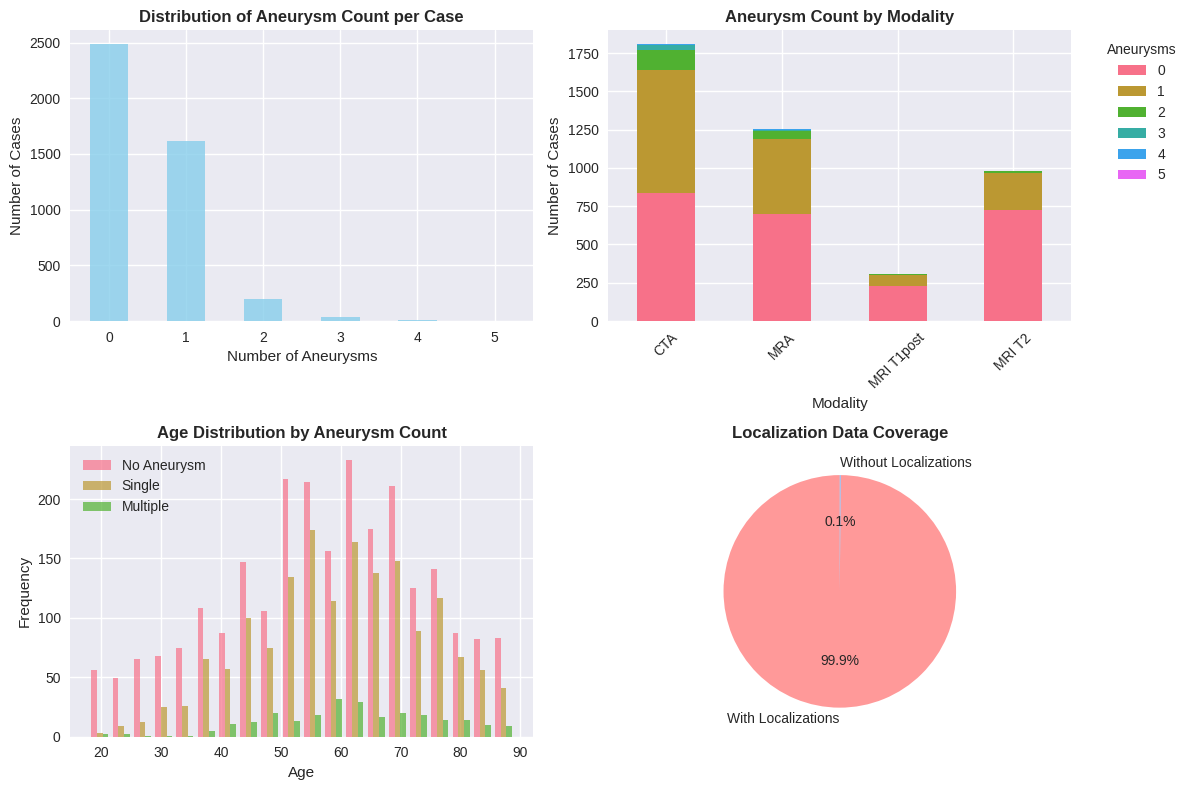


📍 LOCALIZATION ANALYSIS:
   Total localizations: 2,249
   Unique series with localizations: 1,861

   Localization distribution:
   Anterior Communicating Artery: 376 (16.7%)
   Left Supraclinoid Internal Carotid Artery: 342 (15.2%)
   Right Middle Cerebral Artery: 308 (13.7%)
   Right Supraclinoid Internal Carotid Artery: 288 (12.8%)
   Left Middle Cerebral Artery: 222 (9.9%)
   Other Posterior Circulation: 122 (5.4%)
   Basilar Tip: 110 (4.9%)
   Right Infraclinoid Internal Carotid Artery: 103 (4.6%)
   Right Posterior Communicating Artery: 102 (4.5%)
   Left Posterior Communicating Artery: 86 (3.8%)


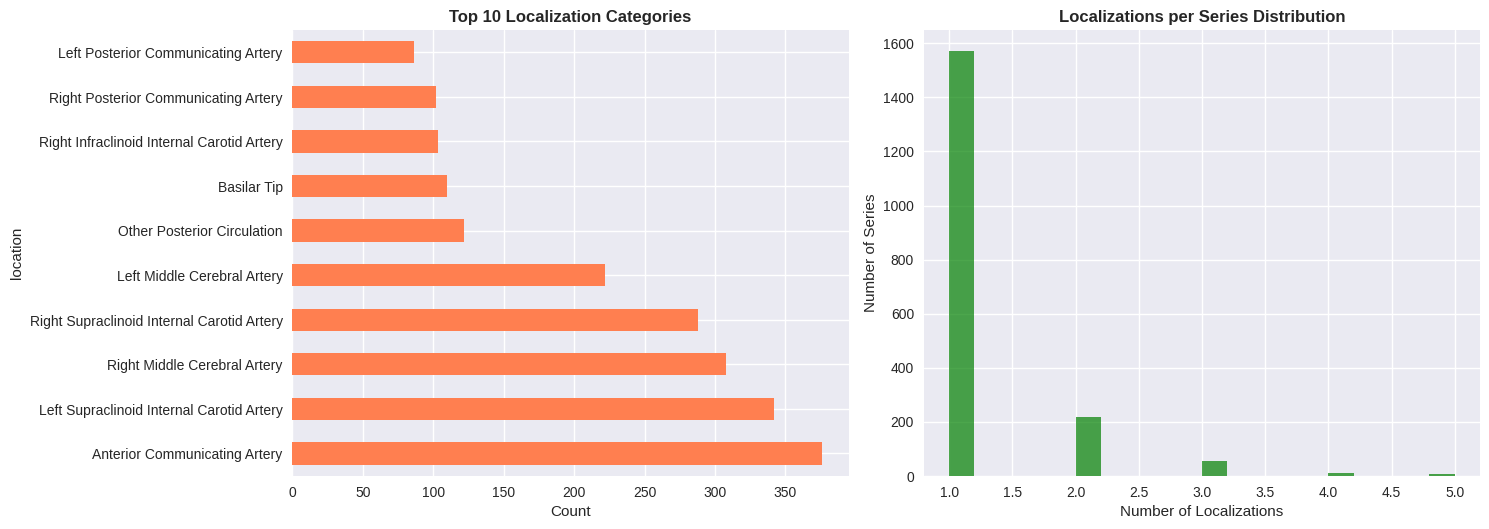


🔬 MODALITY DEEP DIVE:


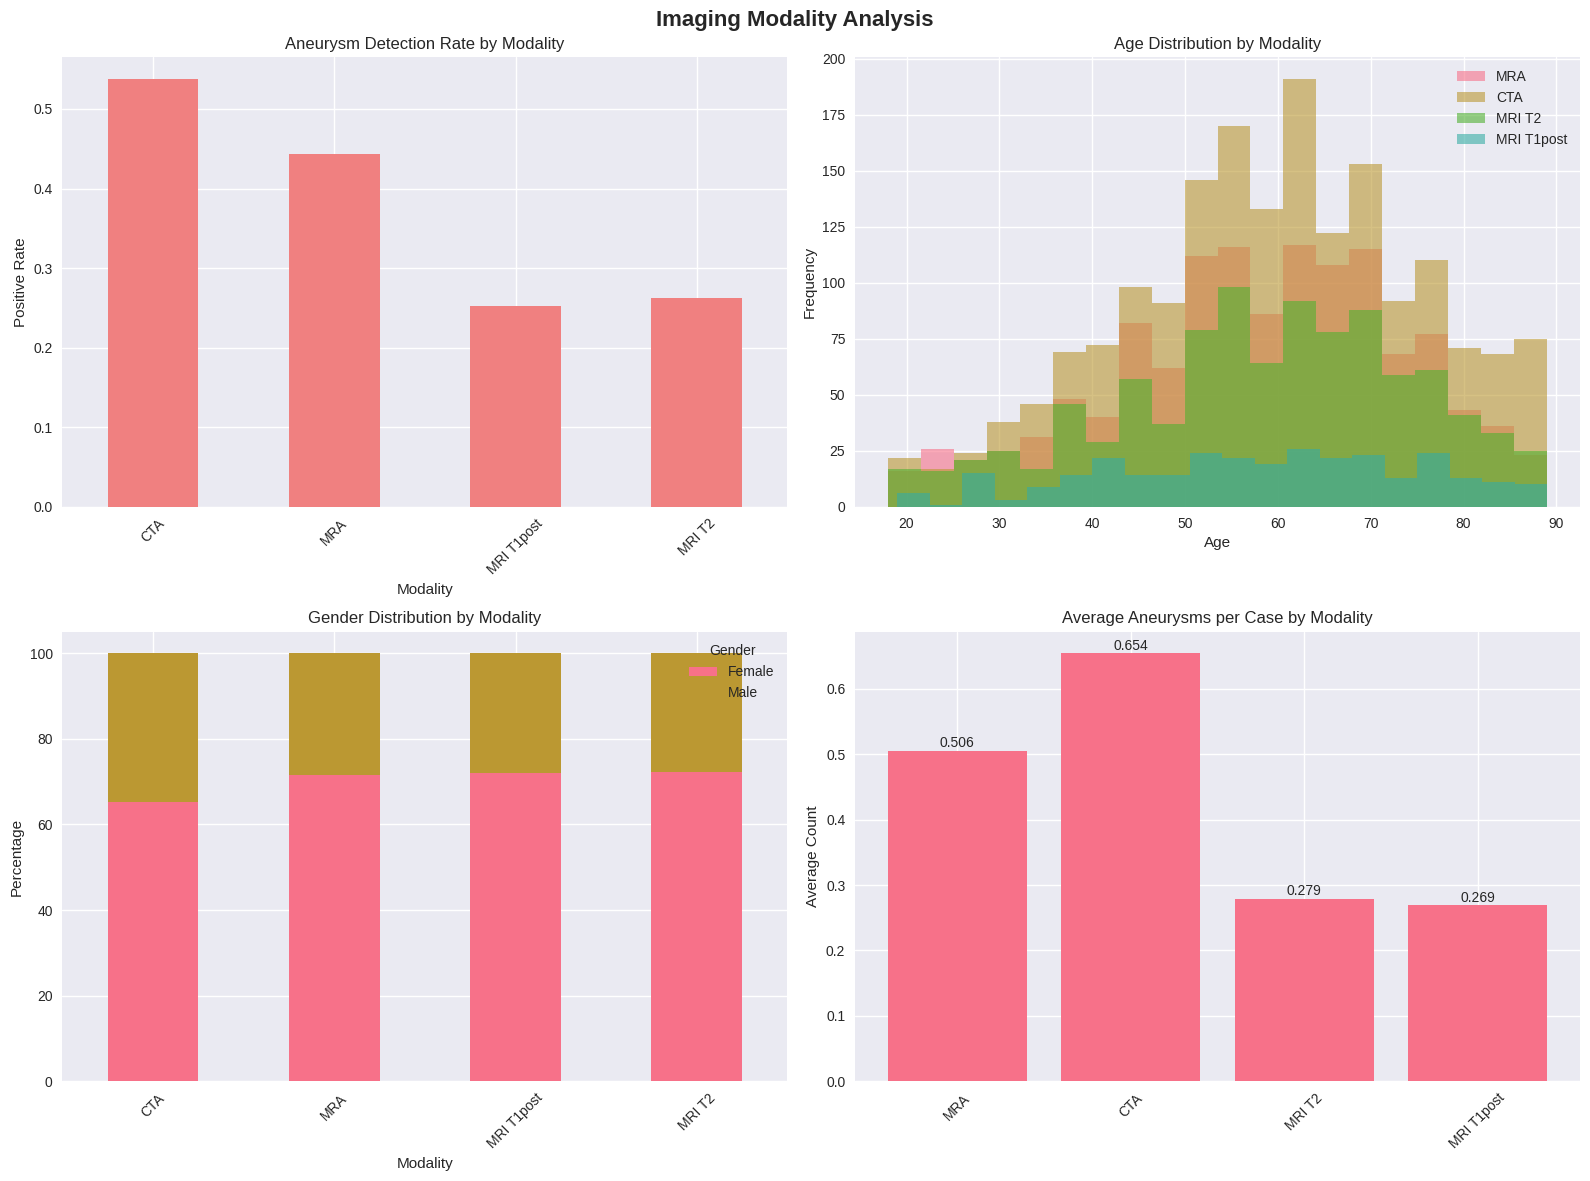


Detailed Modality Statistics:
            Total  Positive   Rate
Modality                          
CTA          1808       973  0.538
MRA          1252       555  0.443
MRI T1post    305        77  0.252
MRI T2        983       258  0.262

🏆 COMPETITION STRATEGY INSIGHTS:
✅ BALANCED DATASET: 42.8% positive rate (excellent for training)
🎯 BEST MODALITY: CTA (53.8% positive rate)
🧠 MOST COMMON LOCATION: AComm (8.35%)
🔢 MULTIPLE ANEURYSMS: 5.7% of cases have >1 aneurysm
👥 GENDER BIAS: Female 46.8% vs Male 34.0%
🧠 SEGMENTATION COVERAGE: 8.2% (limited, use carefully)
📍 LOCALIZATION COVERAGE: 99.9% of positive cases

💡 KEY RECOMMENDATIONS:
   1. Use stratified group k-fold (implemented in data loader)
   2. Handle class imbalance carefully (fairly balanced already)
   3. Consider modality-specific preprocessing
   4. Multi-task learning: detection + localization
   5. Ensemble different modalities
   6. Use segmentations for guided attention (when available)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class RSNAAneurysmEDA:
    """Comprehensive EDA for RSNA Intracranial Aneurysm Detection"""
    
    def __init__(self, data_dir: str):
        self.data_dir = Path(data_dir)
        self.train_df = pd.read_csv(self.data_dir / 'train.csv')
        self.localizers_df = pd.read_csv(self.data_dir / 'train_localizers.csv')
        
        # Define anatomical location columns
        self.location_columns = [
            'Left Infraclinoid Internal Carotid Artery',
            'Right Infraclinoid Internal Carotid Artery', 
            'Left Supraclinoid Internal Carotid Artery',
            'Right Supraclinoid Internal Carotid Artery',
            'Left Middle Cerebral Artery',
            'Right Middle Cerebral Artery',
            'Anterior Communicating Artery',
            'Left Anterior Cerebral Artery', 
            'Right Anterior Cerebral Artery',
            'Left Posterior Communicating Artery',
            'Right Posterior Communicating Artery',
            'Basilar Tip',
            'Other Posterior Circulation'
        ]
        
        # Create short names for plotting
        self.location_short_names = {
            'Left Infraclinoid Internal Carotid Artery': 'L_Infraclinoid_ICA',
            'Right Infraclinoid Internal Carotid Artery': 'R_Infraclinoid_ICA',
            'Left Supraclinoid Internal Carotid Artery': 'L_Supraclinoid_ICA', 
            'Right Supraclinoid Internal Carotid Artery': 'R_Supraclinoid_ICA',
            'Left Middle Cerebral Artery': 'L_MCA',
            'Right Middle Cerebral Artery': 'R_MCA',
            'Anterior Communicating Artery': 'AComm',
            'Left Anterior Cerebral Artery': 'L_ACA',
            'Right Anterior Cerebral Artery': 'R_ACA', 
            'Left Posterior Communicating Artery': 'L_PComm',
            'Right Posterior Communicating Artery': 'R_PComm',
            'Basilar Tip': 'Basilar_Tip',
            'Other Posterior Circulation': 'Other_Posterior'
        }

    def basic_statistics(self):
        """Generate basic dataset statistics"""
        print("🔍 RSNA INTRACRANIAL ANEURYSM DETECTION - DATASET ANALYSIS")
        print("="*70)
        
        total_cases = len(self.train_df)
        positive_cases = self.train_df['Aneurysm Present'].sum()
        
        print(f"📊 BASIC STATISTICS:")
        print(f"   Total Cases: {total_cases:,}")
        print(f"   Positive Cases: {positive_cases:,} ({positive_cases/total_cases*100:.1f}%)")
        print(f"   Negative Cases: {total_cases-positive_cases:,} ({(total_cases-positive_cases)/total_cases*100:.1f}%)")
        print(f"   Total Localizations: {len(self.localizers_df):,}")
        
        print(f"\n🏥 MODALITY DISTRIBUTION:")
        modality_counts = self.train_df['Modality'].value_counts()
        for modality, count in modality_counts.items():
            print(f"   {modality}: {count:,} ({count/total_cases*100:.1f}%)")
        
        print(f"\n👥 DEMOGRAPHICS:")
        print(f"   Age: {self.train_df['PatientAge'].mean():.1f} ± {self.train_df['PatientAge'].std():.1f} years")
        print(f"   Age Range: {self.train_df['PatientAge'].min():.0f} - {self.train_df['PatientAge'].max():.0f} years")
        
        gender_counts = self.train_df['PatientSex'].value_counts()
        for gender, count in gender_counts.items():
            print(f"   {gender}: {count:,} ({count/total_cases*100:.1f}%)")
        
        # Segmentation availability
        seg_dir = self.data_dir / 'segmentations'
        if seg_dir.exists():
            available_segs = len(list(seg_dir.glob('*.nii')))
            print(f"\n🧠 VESSEL SEGMENTATIONS:")
            print(f"   Available: {available_segs:,} ({available_segs/total_cases*100:.1f}%)")

    def plot_class_distribution(self):
        """Plot aneurysm presence distribution"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('🎯 Aneurysm Distribution Analysis', fontsize=16, fontweight='bold')
        
        # Overall distribution
        ax1 = axes[0, 0]
        values = self.train_df['Aneurysm Present'].value_counts()
        colors = ['#FF6B6B', '#4ECDC4']
        wedges, texts, autotexts = ax1.pie(values.values, labels=['Negative', 'Positive'], 
                                          autopct='%1.1f%%', startangle=90, colors=colors)
        ax1.set_title('Overall Aneurysm Distribution', fontweight='bold')
        
        # Distribution by modality
        ax2 = axes[0, 1]
        modality_aneurysm = self.train_df.groupby(['Modality', 'Aneurysm Present']).size().unstack(fill_value=0)
        modality_aneurysm_pct = modality_aneurysm.div(modality_aneurysm.sum(axis=1), axis=0) * 100
        
        modality_aneurysm_pct.plot(kind='bar', ax=ax2, color=colors, width=0.8)
        ax2.set_title('Aneurysm Rate by Modality', fontweight='bold')
        ax2.set_xlabel('Modality')
        ax2.set_ylabel('Percentage')
        ax2.legend(['Negative', 'Positive'])
        ax2.tick_params(axis='x', rotation=45)
        
        # Distribution by age group
        ax3 = axes[1, 0]
        age_bins = [0, 30, 40, 50, 60, 70, 80, 100]
        age_labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
        self.train_df['age_group'] = pd.cut(self.train_df['PatientAge'], bins=age_bins, labels=age_labels)
        
        age_aneurysm = self.train_df.groupby(['age_group', 'Aneurysm Present']).size().unstack(fill_value=0)
        age_aneurysm_pct = age_aneurysm.div(age_aneurysm.sum(axis=1), axis=0) * 100
        
        age_aneurysm_pct.plot(kind='bar', ax=ax3, color=colors, width=0.8)
        ax3.set_title('Aneurysm Rate by Age Group', fontweight='bold')
        ax3.set_xlabel('Age Group')
        ax3.set_ylabel('Percentage')
        ax3.legend(['Negative', 'Positive'])
        ax3.tick_params(axis='x', rotation=45)
        
        # Distribution by gender
        ax4 = axes[1, 1]
        gender_aneurysm = self.train_df.groupby(['PatientSex', 'Aneurysm Present']).size().unstack(fill_value=0)
        gender_aneurysm_pct = gender_aneurysm.div(gender_aneurysm.sum(axis=1), axis=0) * 100
        
        gender_aneurysm_pct.plot(kind='bar', ax=ax4, color=colors, width=0.8)
        ax4.set_title('Aneurysm Rate by Gender', fontweight='bold')
        ax4.set_xlabel('Gender')
        ax4.set_ylabel('Percentage')
        ax4.legend(['Negative', 'Positive'])
        ax4.tick_params(axis='x', rotation=0)
        
        plt.tight_layout()
        plt.show()

    def analyze_anatomical_locations(self):
        """Analyze aneurysm distribution across anatomical locations"""
        print("\n🧠 ANATOMICAL LOCATION ANALYSIS:")
        print("="*50)
        
        # Calculate frequencies for each location
        location_stats = {}
        for col in self.location_columns:
            count = self.train_df[col].sum()
            percentage = count / len(self.train_df) * 100
            location_stats[col] = {'count': count, 'percentage': percentage}
            short_name = self.location_short_names[col]
            print(f"   {short_name}: {count:,} ({percentage:.2f}%)")
        
        # Plot location distribution
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))
        
        # Horizontal bar chart
        ax1 = axes[0]
        locations = [self.location_short_names[col] for col in self.location_columns]
        counts = [self.train_df[col].sum() for col in self.location_columns]
        
        bars = ax1.barh(locations, counts, color=plt.cm.viridis(np.linspace(0, 1, len(locations))))
        ax1.set_title('Aneurysm Count by Anatomical Location', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Number of Aneurysms')
        
        # Add count labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax1.text(width + 5, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center')
        
        # Heatmap of co-occurrence
        ax2 = axes[1]
        correlation_matrix = self.train_df[self.location_columns].corr()
        
        # Use short names for heatmap
        short_names = [self.location_short_names[col] for col in self.location_columns]
        correlation_matrix.index = short_names
        correlation_matrix.columns = short_names
        
        sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                   square=True, ax=ax2, fmt='.2f', cbar_kws={'shrink': 0.8})
        ax2.set_title('Aneurysm Location Co-occurrence Correlation', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def analyze_multiple_aneurysms(self):
        """Analyze cases with multiple aneurysms"""
        print("\n🔢 MULTIPLE ANEURYSM ANALYSIS:")
        print("="*40)
        
        # Count aneurysms per case
        self.train_df['aneurysm_count'] = self.train_df[self.location_columns].sum(axis=1)
        
        count_distribution = self.train_df['aneurysm_count'].value_counts().sort_index()
        print("   Aneurysms per case:")
        for count, cases in count_distribution.items():
            percentage = cases / len(self.train_df) * 100
            print(f"   {count} aneurysms: {cases:,} cases ({percentage:.1f}%)")
        
        # Plot distribution
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        count_distribution.plot(kind='bar', color='skyblue', alpha=0.8)
        plt.title('Distribution of Aneurysm Count per Case', fontweight='bold')
        plt.xlabel('Number of Aneurysms')
        plt.ylabel('Number of Cases')
        plt.xticks(rotation=0)
        
        # Analyze by modality
        plt.subplot(2, 2, 2)
        modality_counts = self.train_df.groupby(['Modality', 'aneurysm_count']).size().unstack(fill_value=0)
        modality_counts.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Aneurysm Count by Modality', fontweight='bold')
        plt.xlabel('Modality')
        plt.ylabel('Number of Cases')
        plt.legend(title='Aneurysms', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        
        # Age analysis for multiple aneurysms
        plt.subplot(2, 2, 3)
        multi_aneurysm = self.train_df[self.train_df['aneurysm_count'] > 1]
        single_aneurysm = self.train_df[self.train_df['aneurysm_count'] == 1]
        no_aneurysm = self.train_df[self.train_df['aneurysm_count'] == 0]
        
        plt.hist([no_aneurysm['PatientAge'], single_aneurysm['PatientAge'], multi_aneurysm['PatientAge']], 
                bins=20, alpha=0.7, label=['No Aneurysm', 'Single', 'Multiple'])
        plt.title('Age Distribution by Aneurysm Count', fontweight='bold')
        plt.xlabel('Age')
        plt.ylabel('Frequency')
        plt.legend()
        
        # Localization analysis
        plt.subplot(2, 2, 4)
        loc_per_aneurysm = len(self.localizers_df) / self.train_df[self.train_df['Aneurysm Present'] == 1].shape[0]
        print(f"\n   Average localizations per positive case: {loc_per_aneurysm:.2f}")
        
        # Series with localizations
        series_with_loc = self.localizers_df['SeriesInstanceUID'].nunique()
        total_positive = self.train_df['Aneurysm Present'].sum()
        
        loc_coverage = series_with_loc / total_positive * 100
        print(f"   Localization coverage: {series_with_loc}/{total_positive} ({loc_coverage:.1f}%)")
        
        # Pie chart of localization coverage
        labels = ['With Localizations', 'Without Localizations']
        sizes = [series_with_loc, total_positive - series_with_loc]
        colors = ['#FF9999', '#66B2FF']
        
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
        plt.title('Localization Data Coverage', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def analyze_localizations(self):
        """Analyze localization coordinates and patterns"""
        if len(self.localizers_df) == 0:
            print("No localization data available")
            return
            
        print("\n📍 LOCALIZATION ANALYSIS:")
        print("="*30)
        
        # Basic stats
        print(f"   Total localizations: {len(self.localizers_df):,}")
        print(f"   Unique series with localizations: {self.localizers_df['SeriesInstanceUID'].nunique():,}")
        
        # Location distribution in localizers
        loc_counts = self.localizers_df['location'].value_counts()
        print(f"\n   Localization distribution:")
        for location, count in loc_counts.head(10).items():
            percentage = count / len(self.localizers_df) * 100
            print(f"   {location}: {count:,} ({percentage:.1f}%)")
        
        # Plot localization patterns
        plt.figure(figsize=(15, 10))
        
        # Coordinates distribution
        coords_data = []
        for idx, row in self.localizers_df.iterrows():
            try:
                # Parse coordinates (assuming format like "x,y" or similar)
                coord_str = str(row['coordinates'])
                if ',' in coord_str:
                    x, y = map(float, coord_str.split(',')[:2])
                    coords_data.append({'x': x, 'y': y, 'location': row['location']})
            except:
                continue
        
        if coords_data:
            coords_df = pd.DataFrame(coords_data)
            
            plt.subplot(2, 2, 1)
            plt.scatter(coords_df['x'], coords_df['y'], alpha=0.6, s=20)
            plt.title('Aneurysm Coordinate Distribution', fontweight='bold')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
            
            plt.subplot(2, 2, 2)
            plt.hist2d(coords_df['x'], coords_df['y'], bins=30, cmap='Blues')
            plt.colorbar(label='Density')
            plt.title('Coordinate Density Heatmap', fontweight='bold')
            plt.xlabel('X Coordinate')
            plt.ylabel('Y Coordinate')
        
        # Location frequency
        plt.subplot(2, 2, 3)
        loc_counts.head(10).plot(kind='barh', color='coral')
        plt.title('Top 10 Localization Categories', fontweight='bold')
        plt.xlabel('Count')
        
        # Series with multiple localizations
        plt.subplot(2, 2, 4)
        loc_per_series = self.localizers_df.groupby('SeriesInstanceUID').size()
        loc_per_series.hist(bins=20, alpha=0.7, color='green')
        plt.title('Localizations per Series Distribution', fontweight='bold')
        plt.xlabel('Number of Localizations')
        plt.ylabel('Number of Series')
        
        plt.tight_layout()
        plt.show()

    def modality_deep_dive(self):
        """Deep analysis of different imaging modalities"""
        print("\n🔬 MODALITY DEEP DIVE:")
        print("="*25)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Imaging Modality Analysis', fontsize=16, fontweight='bold')
        
        # Aneurysm rate by modality
        ax1 = axes[0, 0]
        modality_stats = self.train_df.groupby('Modality').agg({
            'Aneurysm Present': ['count', 'sum', 'mean']
        }).round(3)
        
        modality_stats.columns = ['Total', 'Positive', 'Rate']
        modality_stats['Rate'].plot(kind='bar', ax=ax1, color='lightcoral')
        ax1.set_title('Aneurysm Detection Rate by Modality')
        ax1.set_ylabel('Positive Rate')
        ax1.tick_params(axis='x', rotation=45)
        
        # Age distribution by modality
        ax2 = axes[0, 1]
        for modality in self.train_df['Modality'].unique():
            subset = self.train_df[self.train_df['Modality'] == modality]
            ax2.hist(subset['PatientAge'], alpha=0.6, label=modality, bins=20)
        ax2.set_title('Age Distribution by Modality')
        ax2.set_xlabel('Age')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        # Gender distribution by modality
        ax3 = axes[1, 0]
        modality_gender = pd.crosstab(self.train_df['Modality'], self.train_df['PatientSex'])
        modality_gender_pct = modality_gender.div(modality_gender.sum(axis=1), axis=0) * 100
        modality_gender_pct.plot(kind='bar', ax=ax3, stacked=True)
        ax3.set_title('Gender Distribution by Modality')
        ax3.set_ylabel('Percentage')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend(title='Gender')
        
        # Location preference by modality
        ax4 = axes[1, 1]
        # Calculate average aneurysm count per location for each modality
        modality_locations = []
        for modality in self.train_df['Modality'].unique():
            subset = self.train_df[self.train_df['Modality'] == modality]
            avg_count = subset[self.location_columns].mean().sum()
            modality_locations.append({'Modality': modality, 'Avg_Aneurysms': avg_count})
        
        mod_loc_df = pd.DataFrame(modality_locations)
        bars = ax4.bar(mod_loc_df['Modality'], mod_loc_df['Avg_Aneurysms'])
        ax4.set_title('Average Aneurysms per Case by Modality')
        ax4.set_ylabel('Average Count')
        ax4.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed modality statistics
        print("\nDetailed Modality Statistics:")
        print(modality_stats)

    def generate_competition_insights(self):
        """Generate key insights for competition strategy"""
        print("\n🏆 COMPETITION STRATEGY INSIGHTS:")
        print("="*40)
        
        # Class balance insights
        pos_rate = self.train_df['Aneurysm Present'].mean()
        print(f"✅ BALANCED DATASET: {pos_rate:.1%} positive rate (excellent for training)")
        
        # Modality insights
        best_modality = self.train_df.groupby('Modality')['Aneurysm Present'].mean().idxmax()
        best_rate = self.train_df.groupby('Modality')['Aneurysm Present'].mean().max()
        print(f"🎯 BEST MODALITY: {best_modality} ({best_rate:.1%} positive rate)")
        
        # Location insights
        location_rates = self.train_df[self.location_columns].mean().sort_values(ascending=False)
        print(f"🧠 MOST COMMON LOCATION: {self.location_short_names[location_rates.index[0]]} ({location_rates.iloc[0]:.2%})")
        
        # Multi-aneurysm insights
        multi_rate = (self.train_df['aneurysm_count'] > 1).mean()
        print(f"🔢 MULTIPLE ANEURYSMS: {multi_rate:.1%} of cases have >1 aneurysm")
        
        # Age/Gender insights
        female_rate = self.train_df[self.train_df['PatientSex'] == 'Female']['Aneurysm Present'].mean()
        male_rate = self.train_df[self.train_df['PatientSex'] == 'Male']['Aneurysm Present'].mean()
        print(f"👥 GENDER BIAS: Female {female_rate:.1%} vs Male {male_rate:.1%}")
        
        # Data availability insights
        seg_coverage = 356 / len(self.train_df)  # From earlier analysis
        print(f"🧠 SEGMENTATION COVERAGE: {seg_coverage:.1%} (limited, use carefully)")
        
        # Localization insights
        loc_series = self.localizers_df['SeriesInstanceUID'].nunique()
        pos_cases = self.train_df['Aneurysm Present'].sum()
        loc_coverage = loc_series / pos_cases
        print(f"📍 LOCALIZATION COVERAGE: {loc_coverage:.1%} of positive cases")
        
        print(f"\n💡 KEY RECOMMENDATIONS:")
        print(f"   1. Use stratified group k-fold (implemented in data loader)")
        print(f"   2. Handle class imbalance carefully (fairly balanced already)")
        print(f"   3. Consider modality-specific preprocessing")
        print(f"   4. Multi-task learning: detection + localization")
        print(f"   5. Ensemble different modalities")
        print(f"   6. Use segmentations for guided attention (when available)")

    def run_complete_analysis(self):
        """Run complete EDA pipeline"""
        self.basic_statistics()
        self.plot_class_distribution()
        self.analyze_anatomical_locations()
        self.analyze_multiple_aneurysms()
        self.analyze_localizations()
        self.modality_deep_dive()
        self.generate_competition_insights()

# Usage example
if __name__ == "__main__":
    # Initialize EDA
    data_dir = "/kaggle/input/rsna-intracranial-aneurysm-detection"
    eda = RSNAAneurysmEDA(data_dir)
    
    # Run complete analysis
    eda.run_complete_analysis()